In [1]:
import warnings
from IPython.utils import io

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

with io.capture_output() as captured:
    import sys

    import matplotlib.pyplot as plt
    import mbuild
    import nglview
    import pandas as pd

    import mdtraj
    from MDAnalysis.analysis import rms
    import MDAnalysis as mda

    from tqdm import tqdm
    from rdkit import Chem
    from rdkit.Chem import Draw

    import openmm
    from openff import toolkit, utilities, interchange, models
    from openff.toolkit import topology
    from openff.units import unit
    from openff.interchange.components._packmol import UNIT_CUBE, pack_box

# Build

ocm dmag peta butanol


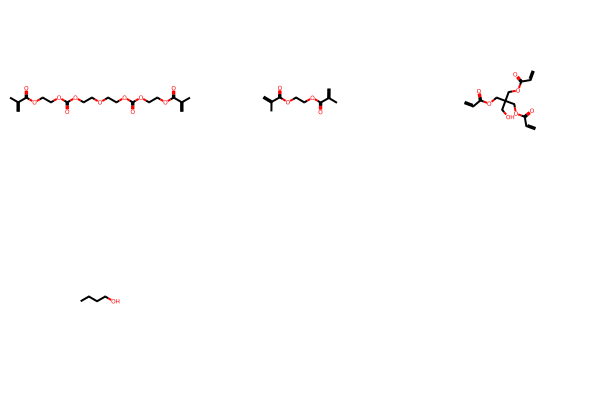

In [2]:
molecules_rdkit = dict(
    ocm=Chem.MolFromSmiles('CC(C(OCCOC(OCCOCCOC(OCCOC(C(C)=C)=O)=O)=O)=O)=C'),
    dmag=Chem.MolFromSmiles('C=C(C)C(OCCOC(C(C)=C)=O)=O'),
    peta=Chem.MolFromSmiles('C=CC(OCC(COC(C=C)=O)(COC(C=C)=O)CO)=O'),
    butanol=Chem.MolFromSmiles('OCCCC'),
)
print(*list(molecules_rdkit.keys()))
Draw.MolsToGridImage(molecules_rdkit.values())

In [3]:
MOLECULES = {}
for molecule_name, rdkit_mol in molecules_rdkit.items():
    mol = toolkit.Molecule.from_rdkit(rdkit_mol)
    MOLECULES[molecule_name] = mol
    mol.generate_conformers(n_conformers=1)
    mol.name = molecule_name

    for atom in mol.atoms:
        atom.metadata["residue_name"] = molecule_name[:3].upper()
    mol.add_hierarchy_scheme(iterator_name='residue',
                             uniqueness_criteria=['residue_name'])


In [6]:
with io.capture_output() as captured:
    a = MOLECULES['ocm2']
    view = a.visualize(backend='nglview')
view

NGLWidget()

In [42]:
class Box:

    def __init__(self, x, rho, substance):
        self.solvent_n = int(x)
        self.substance_n = int((100 - x))
        self.substance = substance
        self.rho = rho
        self.packed = None
        assert substance in ['ocm', 'dmag', 'peta', 'butanol']

    def pack(self,tol=0.5):
        solvent = MOLECULES['butanol']
        substance = MOLECULES[self.substance]
        molecules = []
        n_molecules = []
        if self.substance_n == 0:
            molecules = [solvent]
            n_molecules = [100]
        elif self.substance_n == 100:
            molecules = [substance]
            n_molecules = [100]
        else:
            molecules=[solvent, substance]
            n_molecules = [self.solvent_n, self.substance_n]
        self.packed = pack_box(
            molecules=molecules,
            number_of_copies=n_molecules,
            mass_density=self.rho * unit.kilogram / unit.meter**3,
            tolerance = tol * unit.angstrom,
            box_shape=UNIT_CUBE,
        )

    def save(self, path):
        with open(path, 'w') as file:
            box_j = self.packed.to_json()
            data = {
                'solvent_n': self.solvent_n,
                'substance': self.substance,
                'rho': self.rho,
            }
            box_j = f"{data} ###"+\
                box_j
            file.write(box_j)

    @classmethod
    def load(cls, path):
        with open(path, 'r') as file:
            box_j = file.read()
            data, box_j = box_j.split('###')
            data = eval(data)
            box = Box(
                x=int(data['solvent_n']),
                rho=data['rho'],
                substance=data['substance'],
            )
            box.packed = toolkit.Topology.from_json(box_j)

        return box

    def __repr__(self) -> str:
        return f'<Box: {self.substance}= {self.substance_n} ({self.solvent_n}), rho={self.rho} mg/cm3>'

In [12]:
res = {
    'butanol': [
        (100, 1000),
    ],
    'dmag': [
        (0, 1069),
        (11, 1069),
        (22, 1050),
        (35, 1029),
        (39, 1019),
    ],
    'ocm': [
        (0, 1720),
        (12, 1580),
        (22, 1569),
        (31, 1550),
        (38, 1539),
        (44, 1530),
        (49, 1510),
        (54, 1489),
        (58, 1490),
    ],
    'peta': [
        (0, 1200),
        (19, 1180),
        (30, 1159),
        (41, 1140),
        (49, 1110),
    ]
}

In [44]:
boxes = []
for compound, combinations in res.items():
    for x, rho in combinations:
        box = Box(
            x=x,
            rho=rho,
            substance=compound,
        )
        try:
            box.pack(tol=1)
            box.save(path=f'./boxes/box_{compound}_{x}_{rho}.json')
        except:
            pass

        try:
            box.pack(tol=0.5)
            box.save(path=f'./boxes/box_{compound}_{x}_{rho}.json')
        except:
            continue

boxes

[]

In [21]:
a=boxes[1]
a

<Box: dmag= 100 (0), rho=1069 mg/cm3>

In [35]:
a.pack(tol=1)
with io.capture_output() as captured:
    view = a.packed.visualize()
view

NGLWidget()

In [36]:
a.save(
    path='./box1.json'
)

In [38]:
b = Box.load('./box1.json')
with io.capture_output() as captured:
    view = b.packed.visualize()
view

NGLWidget()

In [ ]:
pack_box(
    molecules=[MOLECULES['butanol1'], MOLECULES['ocm2']],
    number_of_copies=[50] * 2,
    mass_density=500 * unit.kilogram / unit.meter**3,
    box_shape=UNIT_CUBE,
)

In [5]:
box_confs = [{'butanol1': 50, 'ocm2': 50}]
packed = pack_box(
    molecules=[MOLECULES['butanol1'], MOLECULES['ocm2']],
    number_of_copies=[50] * 2,
    mass_density=500 * unit.kilogram / unit.meter**3,
    box_shape=UNIT_CUBE,
)
with io.capture_output() as captured:
    view = packed.visualize()
view

PACKMOLRuntimeError: 
################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Seed for random number generator:      1234567
  Output file: packmol_output.pdb
  Reading coordinate file: 0.pdb
  Reading coordinate file: 1.pdb
  Number of independent structures:            2
  The structures are: 
  Structure            1 :0.pdb(          15  atoms)
  Structure            2 :1.pdb(          55  atoms)
  Maximum number of GENCAN loops for all molecule packing:          400
  Total number of restrictions:            2
  Distance tolerance:    2.0000000000000000     
  Warning: Type of residue numbering not set for structure            1
  Residue numbering set for structure            1 :           0
  Swap chains of molecules of structure            1 : F
  Warning: Type of residue numbering not set for structure            2
  Residue numbering set for structure            2 :           0
  Swap chains of molecules of structure            2 : F
  Number of molecules of type            1 :            1
  Number of molecules of type            2 :            1
  Total number of atoms:           70
  Total number of molecules:            2
  Number of fixed molecules:            0
  Number of free molecules:            2
  Number of variables:           12
  Total number of fixed atoms:            0
  Maximum internal distance of type            1 :    6.2677404221936310     
  Maximum internal distance of type            2 :    23.094333179375408     
  All atoms must be within these coordinates: 
   x: [   -993.60000000000002      ,    1006.4000000000000       ] 
   y: [   -997.28616103565059      ,    1002.7138389643494       ] 
   z: [   -997.03601883430292      ,    1002.9639811656971       ] 
  If the system is larger than this, increase the sidemax parameter. 

################################################################################

  Building initial approximation ... 

################################################################################

  Adjusting initial point to fit the constraints 

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

  Molecules of type:            1

  Packing:|0                                                             100%|
          |******************************************

  Restraint-only function value:    3.4442310626249694E-007
  Maximum violation of the restraints:    3.4442310626249694E-007

--------------------------------------------------------------------------------

  Molecules of type:            2

  Packing:|0                                                             100%|
          |******************************************************************|
          |******************************************************************|
  Fixing bad orientations ...      1 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770871735     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   250.38854311156067     
  Packing:|0                                                             100%|
          |******************************************************************|
          |******************************************************************|
  Fixing bad orientations ...      2 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   244.51769990989879     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790760     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...      3 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790760     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790758     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...      4 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790758     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790767     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...      5 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790767     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790748     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...      6 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790748     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790753     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...      7 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790753     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790758     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...      8 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790758     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.85817630609294     
  Packing:|0                                                             100%|
          |***********************************
  Fixing bad orientations ...      9 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790756     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790756     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     10 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790756     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790753     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     11 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790753     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.73322890039329     
  Packing:|0                                                             100%|
          |*********************
  Fixing bad orientations ...     12 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790751     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790757     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     13 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790757     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71952917002088     
  Packing:|0                                                             100%|
          |**************
  Fixing bad orientations ...     14 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790768     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   109.03389299865229     
  Packing:|0                                                             100%|
          |******************************************************************|

  Fixing bad orientations ...     15 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790758     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790747     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     16 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790747     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790758     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     17 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790758     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770792663     
  Packing:|0                                                             100%|
          |*******
  Fixing bad orientations ...     18 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790764     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790773     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     19 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790773     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790767     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     20 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790767     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790758     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     21 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790758     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790763     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     22 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790763     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71916072190055     
  Packing:|0                                                             100%|
          |**************
  Fixing bad orientations ...     23 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790757     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790763     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     24 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790763     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790767     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     25 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790767     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790768     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     26 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790768     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790753     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     27 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790753     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790760     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     28 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790760     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790761     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     29 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790761     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790754     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     30 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790754     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770792239     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     31 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790761     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790756     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     32 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790756     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770791146     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     33 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790756     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790770     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     34 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790770     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790758     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     35 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790758     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790757     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     36 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790757     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790764     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     37 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790764     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   104.71915770790760     
  Packing:|0                                                             100%|
          |
  Fixing bad orientations ...     38 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71915770790760     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   128.06966241530645     
  Packing:|0                                                             100%|
          |******************************************************************|
          |******************************************************************|
  Fixing bad orientations ...     39 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   104.71928152015259     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   247.29778784921015     
  Packing:|0                                                             100%|
          |******************************************************************|
          |******************************************************************|
  Fixing bad orientations ...     40 of     40
  Moving worst molecules ... 
  Function value before moving molecules:   246.28838775217605     
  Type         2 molecules with non-zero contributions:  100.00%
  Moving         1 molecules of type         2
  New positions will be based on good molecules (movebadrandom is not set) 
   Moving:|0                                                             100%|
          |******************************************************************|
  Function value after moving molecules:   236.40372440561470     

  Restraint-only function value:    236.40372440561470     
  Maximum violation of the restraints:    22.598818884564125     
  ERROR: Packmol was unable to put the molecules
         in the desired regions even without
         considering distance tolerances. 
         Probably there is something wrong with
         the constraints, since it seems that
         the molecules cannot satisfy them at
         at all. 
         Please check the spatial constraints and
         try again.
  >The maximum number of cycles (          40 ) was achieved.
   You may try increasing it with the nloop0 keyword, as in: nloop0 1000 


In [ ]:
with open('results/box_top.json', 'w') as file:
    box_j = packed.to_json()
    file.write(box_j)

In [27]:
with open('box.json', 'r') as file:
    box_j = file.read()
    box2 = toolkit.Topology.from_json(box_j)

In [31]:
('Data ###' +box_j).split('###')

['Data ',
 '{"aromaticity_model": "OEAroModel_MDL", "constrained_atom_pairs": {}, "box_vectors": [3.6610614483362425, 0.0, 0.0, 0.0, 3.6610614483362425, 0.0, 0.0, 0.0, 3.6610614483362425], "box_vectors_unit": "nanometer", "molecules": [{"name": "butanol1", "atoms": [{"atomic_number": 8, "formal_charge": 0, "is_aromatic": false, "stereochemistry": null, "name": "", "metadata": {"residue_name": "BUT"}}, {"atomic_number": 6, "formal_charge": 0, "is_aromatic": false, "stereochemistry": null, "name": "", "metadata": {"residue_name": "BUT"}}, {"atomic_number": 6, "formal_charge": 0, "is_aromatic": false, "stereochemistry": null, "name": "", "metadata": {"residue_name": "BUT"}}, {"atomic_number": 6, "formal_charge": 0, "is_aromatic": false, "stereochemistry": null, "name": "", "metadata": {"residue_name": "BUT"}}, {"atomic_number": 6, "formal_charge": 0, "is_aromatic": false, "stereochemistry": null, "name": "", "metadata": {"residue_name": "BUT"}}, {"atomic_number": 1, "formal_charge": 0, "i

In [ ]:
ff = toolkit.ForceField('openff_unconstrained-2.1.0.offxml')
box_parametrized = interchange.Interchange.from_smirnoff(
    force_field=ff,
    topology=box2,
)

In [ ]:
with io.capture_output() as captured:
    view = box_parametrized.topology.visualize()
view

In [ ]:
box_parametrized.minimize()

In [ ]:
box_parametrized.to_pdb('box_min.pdb')

# Simulation

In [ ]:
# Logging options.
trj_freq = 10  # number of steps per written trajectory frame
data_freq = 10  # number of steps per written simulation statistics

# Integration options
time_step = 2 * openmm.unit.femtoseconds  # simulation timestep
temperature = 300 * openmm.unit.kelvin  # simulation temperature
friction = 1 / openmm.unit.picosecond  # friction constant

integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

In [ ]:
sim = box_parametrized.to_openmm_simulation(integrator=integrator)
sim.context.setVelocitiesToTemperature(temperature)
reporters = [
    openmm.app.StateDataReporter(sys.stdout, trj_freq, step=True),
    openmm.app.DCDReporter(
        'traj.dcd',
        trj_freq,  # enforcePeriodicBox=False,
    ),
    openmm.app.PDBReporter('solve2.pdb', trj_freq),
]
sim.reporters.extend(reporters)

In [ ]:
sim.step(10000)

# Results

In [3]:
universe = mda.Universe('box_min.pdb', 'traj.dcd')


/home/way/miniforge3/envs/MolModel/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


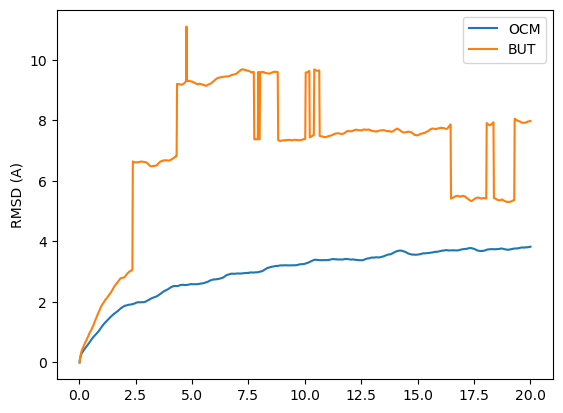

In [26]:
r_ocm = rms.RMSD(universe, universe, 'resname OCM')
r_ocm.run()
df_ocm = pd.DataFrame(r_ocm.results.rmsd, columns=['Frame', 'Time', 'OCM'])

r_but = rms.RMSD(universe, universe, 'resname BUT')
r_but.run()
df_but = pd.DataFrame(r_but.results.rmsd, columns=['Frame', 'Time', 'BUT'])

fig,ax= plt.subplots()
ax.plot(df_ocm['Time'],df_ocm['OCM'],label='OCM')
ax.plot(df_but['Time'],df_but['BUT'],label='BUT')
ax.set_ylabel('RMSD (A)')
ax.legend()

In [27]:
import numpy as np

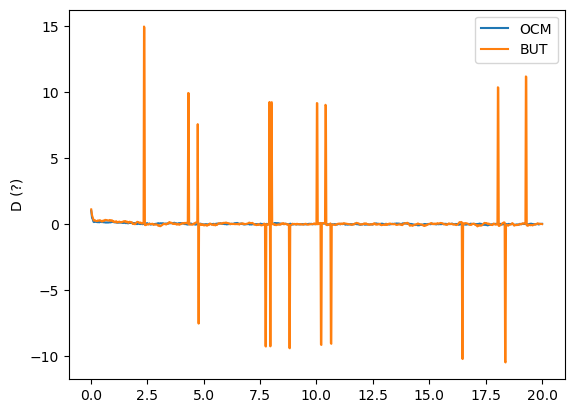

In [30]:
# ocm
x= df_ocm['Time']
y= df_ocm['OCM']
d=np.gradient(y,x)/6

fig,ax= plt.subplots()
ax.plot(x,d,label='OCM')

x= df_but['Time']
y= df_but['BUT']
d=np.gradient(y,x)/6

ax.plot(x,d,label='BUT')
ax.set_ylabel('D (?)')

ax.legend()